In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
def parseData(df):
    """
    预处理数据
    """
    df['rentType'][df['rentType']=='--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
    # 将buildYear列转换为整型数据
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')
    tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    # 处理pv和uv的空值
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    
    # 去掉部分特征
#     df.drop('communityName',axis=1, inplace=True)
    df.drop('city',axis=1,inplace=True)
    
    return df

In [3]:
def washData(df_train, df_test):
    """
    清洗数据
    """
    df_train = df_train.drop(df_train[df_train['area']<15].index)   
    df_train = df_train.drop(df_train[df_train['area']>=200].index)   
    df_train = df_train[df_train['tradeMoney']<=40000]
#     df_train = df_train[df_train['area']<=700]
#     df_train = df_train[df_train['tradeMoney']<=100000]
    
    df_train.drop('ID', axis=1, inplace=True)
    df_test.drop('ID', axis=1,inplace=True)
    
    return df_train, df_test

In [4]:
### 计算是2018年的第几天
def is_leap_year(year):
    if year % 4 == 0 and year % 100 != 0 or year % 400 == 0:
        return True
    return False
def which_day(df):
    year = int(df.split('/')[0])
    month = int(df.split('/')[1])
    day = int(df.split('/')[2])
    month_of_day31 = [1,3,5,7,8,10,12]
    month_of_day30 = [4,6,9,11]
    feb_month = 2
    if month ==1 :
        return day
    if month == 2:
        return day + 31
    days_of_31_num = 0
    days_of_30_num = 0
    ## 31天月份数
    for days_of_31 in month_of_day31:
        if days_of_31 < month:
            days_of_31_num += 1
        else:
            break
    ## 30天月份数
    for days_of_30 in month_of_day31:
        if days_of_30 < month:
            days_of_30_num += 1
        else:
            break
    return days_of_31_num * 31 + days_of_30_num * 30 +(29 if is_leap_year(year) else 28) + day 

In [5]:
def get_new_columns(name, aggs):
    l = []
    for k in aggs.keys():
        for agg in aggs[k]:
            if str(type(agg)) == "<class 'function'>":
                l.append(name + '_' + k + '_' + 'other')
            else:
                l.append(name + '_' + k + '_' + agg)
    return l

In [6]:
def feature(df):
    """
    特征
    """
    # 将houseType 进行细化，转化为‘房间数’，‘厅数’，‘卫生间数’，进行组合，求房间总数
    def parseRoom(info, index):
        res = int(info[index*2])
        return res
    df.insert(3,'shi',None)
    df.insert(4, 'ting', None)
    df.insert(5, 'wei', None)
    df['shi'] = df['houseType'].apply(parseRoom, index=0)
    df['ting'] = df['houseType'].apply(parseRoom, index=1)
    df['wei'] = df['houseType'].apply(parseRoom, index=2)
#     df['pv/uv'] = df['pv'] / df['uv']
    df['all_rooms'] = df['shi'] + df['ting'] + df['wei'] ##
    df['mean_area'] = df['area']/df['all_rooms'] ##单个房间占的面积
    
    df['shi/all_rooms'] = df['shi']/df['all_rooms']
    df['ting/all_rooms'] = df['ting']/df['all_rooms']
    df['wei/all_rooms'] = df['wei']/df['all_rooms']
    
    df['shi_area'] = df['shi/all_rooms']*df['area']  ### 室厅卫分别的面积
    df['ting_area'] = df['ting/all_rooms']*df['area']
    df['wei_area'] = df['wei/all_rooms']*df['area']
    
    ### 交易时间特征  因都是2018年，没必要提取年份特征，包含 月 日  该年第几天
    df['month'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))
    df['day'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1])) ##将时间特征进行放大
    ### 看看交易时间是2018年的第几天
    df['whichday'] = df['tradeTime'].apply(which_day)
    
    ### 配套设施数量 
    df['state_num'] = df['subwayStationNum'] + df['busStationNum']
    df['school_num'] = df['interSchoolNum'] + df['schoolNum'] + df['privateSchoolNum']
    df['medical_num'] = df['hospitalNum'] + df['drugStoreNum']
    df['other_num'] = df['gymNum'] + df['bankNum'] + df['shopNum'] + df['parkNum'] + df['mallNum'] + df['superMarketNum']
    
    df = df.drop(['subwayStationNum','busStationNum', 'schoolNum','interSchoolNum', 'privateSchoolNum',
                  'hospitalNum', 'drugStoreNum','gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum', 
                  'superMarketNum'], axis=1)
    ###从任务二的特征重要图来看，新房、二手房的成交均价对结果影响较大，这里 挖掘一些这两个的特征
    f_a = ['region',  'plate', 'communityName']
    f_b = ['tradeMeanPrice', 'tradeNewMeanPrice']

    aggs = {}
    for b in f_b:
        aggs[b] = ['mean', 'max', 'min', 'std']
    
    for a in f_a:
        for b in f_b:
            tmp = df.groupby(a, as_index=False).agg(aggs)
            tmp.columns = [a] + get_new_columns(a, aggs)
            df = pd.merge(df, tmp, on=a, how='left')
    
    ## pv uv  也是比较重要的特征，
    df['look/pv'] = df['lookNum'] / df['pv']
    df['look/uv'] = df['lookNum'] /df['uv']
    
    ## 成交面积/供应面积
    df['tradearealand/supplyarealand'] = df['tradeLandArea'] / df['supplyLandArea']
    df['tradearealand/supplyarealand'].fillna(0,inplace=True)
    
    df['num_communityName'] = df['communityName'].apply(lambda x: int(x[3: 7]))
    
    
    df.drop('houseType', axis=1, inplace=True)
    df.drop('tradeTime', axis=1, inplace=True)
    df.drop('communityName', axis=1, inplace=True)
    
    categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']
    
#     categorical_feats = ['communityName','rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']
    return df, categorical_feats

In [7]:
def getData(feature):
    """
    获取数据
    """
    train = pd.read_csv('./train_data.csv')
    test = pd.read_csv('./test_a.csv')
    
    train = parseData(train)
    test = parseData(test)
    train, test = washData(train, test)
    
    train, col = feature(train)
    test, col = feature(test)
    
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    
    return train, test, target, features, categorical_feats

# 训练模型

In [8]:
train, test, target, features, categorical_feats = getData(feature)
print(train.shape, test.shape)

d:\tools\anaconda3.5.0\envs\house\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(36399, 102) (2469, 102)


In [9]:
features

Index(['area', 'rentType', 'shi', 'ting', 'wei', 'houseFloor', 'totalFloor',
       'houseToward', 'houseDecoration', 'region',
       ...
       'communityName_tradeMeanPrice_min_y',
       'communityName_tradeMeanPrice_std_y',
       'communityName_tradeNewMeanPrice_mean_y',
       'communityName_tradeNewMeanPrice_max_y',
       'communityName_tradeNewMeanPrice_min_y',
       'communityName_tradeNewMeanPrice_std_y', 'look/pv', 'look/uv',
       'tradearealand/supplyarealand', 'num_communityName'],
      dtype='object', length=102)

In [10]:
categorical_feats

['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']

#### 类别特征编码

onehot编码

In [11]:
data=pd.concat([train,test])
print(data.shape)

(38868, 102)


In [12]:
for s in categorical_feats:
    data=pd.concat([data,pd.get_dummies(data[s],prefix=s+'_')],axis=1)
    data.drop(s,axis=1,inplace=True)

In [13]:
feature = data.columns.tolist()
for fea in feature:
    if fea not in categorical_feats:
        data[fea].apply(lambda x: round(x, 1))
    

In [14]:
data

,area,shi,ting,wei,totalFloor,buildYear,saleSecHouseNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,...,plate__BK00057,plate__BK00058,plate__BK00059,plate__BK00060,plate__BK00061,plate__BK00062,plate__BK00063,plate__BK00064,plate__BK00065,plate__BK00066
0,68.06,2,1,1,16,1953,0,355584000,7411.98,47974.22551,...,0,0,0,0,0,0,0,1,0,0
1,125.55,3,2,2,14,2007,0,5000000,122.83,40706.66775,...,0,0,0,0,0,0,0,0,0,0
2,132.00,3,2,2,32,1994,3,1687284798,49071.30,34384.35089,...,0,0,0,0,0,0,0,0,0,0
3,57.00,1,1,1,17,1994,0,468272888,22809.70,20529.55050,...,0,0,0,0,0,0,0,0,0,0
4,129.00,3,2,3,2,1994,1,108851470,4463.62,24386.36577,...,0,0,0,0,0,0,0,0,0,0
5,78.94,2,2,1,18,2014,6,363542000,18080.57,20106.77761,...,0,0,0,0,0,0,0,0,0,0
6,76.00,2,1,1,5,1997,0,960190000,42188.64,22759.44425,...,0,0,0,0,0,0,0,0,0,0
7,120.55,3,2,1,6,2007,0,960190000,42188.64,22759.44425,...,0,0,0,0,0,0,0,0,0,0
8,83.00,3,1,1,5,1993,0,624380000,29637.50,21067.22902,...,0,0,0,0,0,0,0,0,0,0
9,89.00,2,1,1,6,1994,0,624380000,29637.50,21067.22902,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data.isnull().sum().sort_values(ascending=False)

communityName_tradeMeanPrice_std_y       3478
communityName_tradeMeanPrice_std_x       3478
communityName_tradeNewMeanPrice_std_y    3478
communityName_tradeNewMeanPrice_std_x    3478
plate_tradeMeanPrice_std_y                  2
plate_tradeNewMeanPrice_std_x               2
plate_tradeNewMeanPrice_std_y               2
plate_tradeMeanPrice_std_x                  2
region_tradeMeanPrice_std_x                 1
region_tradeNewMeanPrice_std_y              1
region_tradeMeanPrice_std_y                 1
region_tradeNewMeanPrice_std_x              1
plate_tradeMeanPrice_mean_y                 0
region_tradeNewMeanPrice_min_x              0
plate_tradeNewMeanPrice_min_x               0
plate_tradeNewMeanPrice_max_x               0
plate_tradeNewMeanPrice_mean_x              0
region_tradeMeanPrice_mean_y                0
region_tradeNewMeanPrice_mean_y             0
plate_tradeMeanPrice_min_x                  0
plate_tradeMeanPrice_max_x                  0
plate_tradeMeanPrice_mean_x       

In [16]:
data['communityName_tradeMeanPrice_std_y'].fillna(0,inplace=True)
data['communityName_tradeMeanPrice_std_x'].fillna(0,inplace=True)
data['communityName_tradeNewMeanPrice_std_y'].fillna(0,inplace=True)
data['communityName_tradeNewMeanPrice_std_x'].fillna(0,inplace=True)
data['plate_tradeMeanPrice_std_y'].fillna(0,inplace=True)
data['plate_tradeNewMeanPrice_std_x'].fillna(0,inplace=True)
data['plate_tradeNewMeanPrice_std_y'].fillna(0,inplace=True)
data['plate_tradeMeanPrice_std_x'].fillna(0,inplace=True)
data['region_tradeMeanPrice_std_x'].fillna(0,inplace=True)
data['region_tradeNewMeanPrice_std_y'].fillna(0,inplace=True)
data['region_tradeMeanPrice_std_y'].fillna(0,inplace=True)
data['region_tradeNewMeanPrice_std_x'].fillna(0,inplace=True)

In [17]:
train=data[0:36399]
test=data[36399:]
print(train.shape, test.shape)   ###这里写的方法有点蠢，不过能实现想要的就好了

(36399, 197) (2469, 197)


#### 进行类别特征的数值编码

In [11]:
import sklearn.preprocessing as preprocessing
le = preprocessing.LabelEncoder()
for label in categorical_feats:
    le.fit(train[label])
    train[label] = le.transform(train[label])
for label in categorical_feats:
    le.fit(test[label])
    test[label] = le.transform(test[label])
    

# 特征选择

### 1 pearson 相关系数


皮尔森相关系数是一种最简单的，能帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性，结果的取值区间为 [-1，1] ， -1 表示完全的负相关(这个变量下降，那个就会上升)， [公式] 表示完全的正相关， [公式] 表示没有线性相关。Pearson Correlation速度快、易于计算，经常在拿到数据(经过清洗和特征提取之后的)之后第一时间就执行。

In [21]:
xx = train
yy = target
for col in xx.columns:
    if xx[col].dtype.name == 'category':
        xx = xx.drop([col], axis=1)

In [19]:
xx.isnull().sum().sort_values(ascending=False)

communityName_tradeMeanPrice_std_x        1009
communityName_tradeNewMeanPrice_std_x     1009
communityName_tradeNewMeanPrice_std_y     1009
communityName_tradeMeanPrice_std_y        1009
plate_tradeNewMeanPrice_std_x                1
region_tradeNewMeanPrice_std_y               1
plate_tradeMeanPrice_std_y                   1
plate_tradeNewMeanPrice_std_y                1
region_tradeMeanPrice_std_y                  1
region_tradeNewMeanPrice_std_x               1
region_tradeMeanPrice_std_x                  1
plate_tradeMeanPrice_std_x                   1
uv                                           0
totalWorkers                                 0
whichday                                     0
newWorkers                                   0
residentPopulation                           0
day                                          0
month                                        0
pv                                           0
wei/all_rooms                                0
ting/all_room

In [ ]:
## 有nan 有的值很大，没办法直接用
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr

#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数
x_new = SelectKBest(lambda X, Y: array(map(lambda x:pearsonr(x, Y), X.T)).T, k=50).fit_transform(xx, yy)
x_new

### 2 卡方

In [ ]:
from sklearn.festure_selection import chi2
x_chi2_new = SelectKBest(chi2, k=30).fit_transform(xx, yy)
x_chi2_new

### 3.Wrapper （RFE）


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

RFE(estimator=LogisticRegression(), n_features_to_select=2).fit_transform(xx, yy)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 4 Embedded
- 基于惩罚项的特征选择法

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
 
#带L1惩罚项的逻辑回归作为基模型的特征选择
SelectFromModel(LogisticRegression(penalty="l1", C=0.1)).fit_transform(xx, yy)


- 基于树模型的特征选择

### 模型构建

In [27]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### 1.GBDT   存在比较大的值，无法使用

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
# xgb_model, score = rmsle_cv(GBoost)
# print("GBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

d:\tools\anaconda3.5.0\envs\house\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### 2.xgb

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='neg_mean_squared_error',
                                   n_jobs=4, cv=skf.split(train,target), verbose=3, random_state=1001 )

# Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(train,target)
# timer(start_time) # timing ends here for "start_time" variable
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)

d:\tools\anaconda3.5.0\envs\house\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [31]:
# import xgboost as xgb

# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)
# xgb_model, score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

d:\tools\anaconda3.5.0\envs\house\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\tools\anaconda3.5.0\envs\house\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\tools\anaconda3.5.0\envs\house\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\tools\anaconda3.5.0\envs\house\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\tools\anaconda3.5.0\envs\house\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

Xgboost score: 1095.6085 (28.3769)



In [37]:
xgb_params = {'eta': 0.05, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.5, 'alpha': 0.2,
                      'objective': 'reg:gamma', 'eval_metric': 'rmse', 'silent': True, 'nthread': -1
                      }


folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = xgb.DMatrix(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(train.iloc[val_idx], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = xgb.train(xgb_params, trn_data, num_round, evals = watchlist, verbose_eval=500, early_stopping_rounds = 200)
    
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(train.iloc[val_idx]), ntree_limit=clf.best_ntree_limit)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_xgb += clf.predict(xgb.DMatrix(test),ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_xgb)))

fold 0
[0]	train-rmse:5756	valid_data-rmse:5822.71
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:963.926	valid_data-rmse:1150.61
[1000]	train-rmse:770.661	valid_data-rmse:1088.5
[1500]	train-rmse:677.404	valid_data-rmse:1073.99
Stopping. Best iteration:
[1411]	train-rmse:690.002	valid_data-rmse:1073.18

fold 1
[0]	train-rmse:5773.32	valid_data-rmse:5753.69
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:965.058	valid_data-rmse:1165.27
[1000]	train-rmse:774.493	valid_data-rmse:1119.85
[1500]	train-rmse:679.818	valid_data-rmse:1110.75
Stopping. Best iteration:
[1396]	train-rmse:693.661	valid_data-rmse:1108.4

fold 2
[0]	train-rmse:5789.06	valid_data-rmse:5690.1
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early

#### 3.catboost

In [26]:
# # Training and Validation Set
# X_train, X_valid, y_train, y_valid = train_test_split(
#     train, target, test_size=0.10, random_state=23)

# # Prepare Categorical Variables
# def column_index(df, query_cols):
#     cols = df.columns.values
#     sidx = np.argsort(cols)
#     return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
# categorical_features_pos = column_index(train,categorical_feats)


In [28]:
# from catboost import CatBoostRegressor
# cb_model = CatBoostRegressor(iterations=700,
#                              learning_rate=0.02,
#                              depth=12,
#                              eval_metric='RMSE',
#                              random_seed = 23,
#                              bagging_temperature = 0.2,
#                              od_type='Iter',
#                              metric_period = 75,
#                              od_wait=100)
# cb_model.fit(X_train, y_train, eval_set=(X_valid,y_valid), cat_features=categorical_features_pos, use_best_model=True,verbose=True)

0:	learn: 5668.3675488	test: 5647.1724194	best: 5647.1724194 (0)	total: 6.75s	remaining: 1h 18m 39s
75:	learn: 1895.4909621	test: 1995.4290051	best: 1995.4290051 (75)	total: 7m 18s	remaining: 59m 58s


KeyboardInterrupt: 

In [39]:
import catboost as cat
ctb_params = {

    'iterations': 700,
    'learning_rate': 0.02,
    'depth': 12,
    'eval_metric': 'RMSE',
    'random_seed' : 23,
    'bagging_temperature': 0.2,
    'od_type': 'Iter',
    'metric_period':  75,
    'od_wait': 100
    }

folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_cat = np.zeros(len(train))
predictions_cat = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)

#     num_round = 10000
    clf = cat.CatBoostRegressor(**ctb_params)
    clf.fit(train.iloc[trn_idx], target.iloc[trn_idx], early_stopping_rounds=200, verbose_eval=3000,
                use_best_model=True,eval_set=(train.iloc[val_idx], target.iloc[val_idx]))
    oof_cat[val_idx] = clf.predict(train.iloc[val_idx])
    predictions_cat += clf.predict(test) / folds.n_splits
    predictions_cat += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_cat)))

fold 0


0:	learn: 5655.0015187	test: 5720.6555390	best: 5720.6555390 (0)	total: 6.55s	remaining: 1h 16m 15s


KeyboardInterrupt: 

#### 4. lgb

In [14]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [15]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0


d:\tools\anaconda3.5.0\envs\house\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\tools\anaconda3.5.0\envs\house\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 895.646	valid_1's rmse: 1075.58
[1000]	training's rmse: 779.85	valid_1's rmse: 1040.18
[1500]	training's rmse: 716.146	valid_1's rmse: 1028.26
[2000]	training's rmse: 671.977	valid_1's rmse: 1023.53
[2500]	training's rmse: 637.47	valid_1's rmse: 1020.41
[3000]	training's rmse: 609.311	valid_1's rmse: 1018.31
[3500]	training's rmse: 585.066	valid_1's rmse: 1016.44
[4000]	training's rmse: 564.066	valid_1's rmse: 1015.21
[4500]	training's rmse: 545.221	valid_1's rmse: 1014.03
[5000]	training's rmse: 528.006	valid_1's rmse: 1013.4
[5500]	training's rmse: 512.734	valid_1's rmse: 1012.32
[6000]	training's rmse: 498.495	valid_1's rmse: 1011.76
Early stopping, best iteration is:
[6013]	training's rmse: 498.133	valid_1's rmse: 1011.71
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 892.361	valid_1's rmse: 1119.16
[1000]	training's rmse: 781.686	valid_1's rmse: 1088.

# 特征贡献值

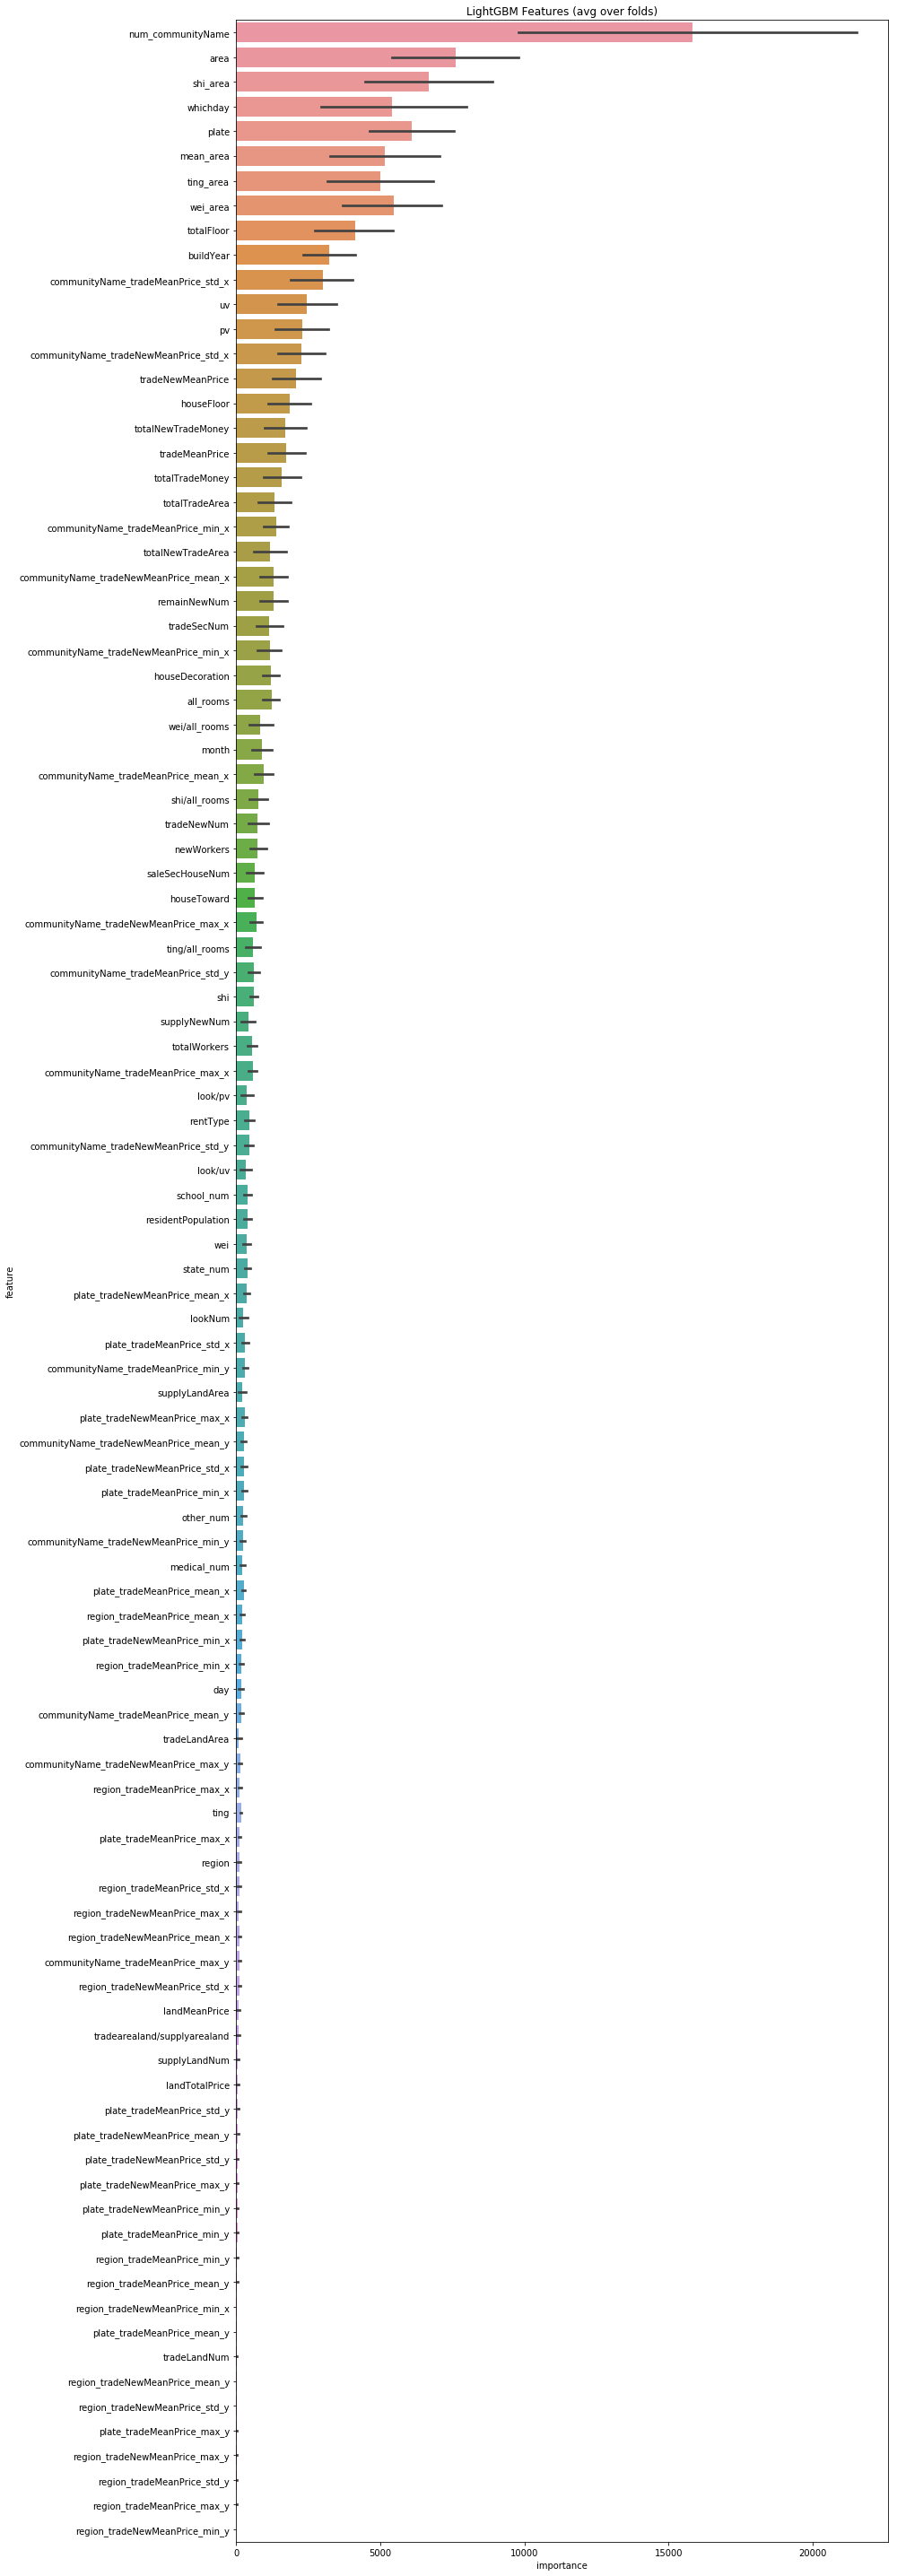

In [16]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# 生成提交数据

In [16]:
pd.DataFrame(predictions_lgb).apply(round).to_csv('submit.csv',na_rep='\n',index=False,encoding='utf8',header=False)

In [17]:
from sklearn.metrics import r2_score
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))
    # a榜测分
    conmbine1 = pd.read_csv("./sub_a_913.csv",engine = "python",header=None)
    score1 = r2_score(pred, conmbine1)
    print("对比913分数:{}".format(score1))

In [18]:
score = online_score(predictions_lgb)

预测结果最大值：17246.40124617306,预测结果最小值：822.9390140363955
对比913分数:0.9576892564120442


### 总结：
- 将小区名当作类别特征时，最终可达 95.75
    预测结果最大值：17250.272605874594,预测结果最小值：809.4386627186016 
    对比913分数:0.9575305313833965
- 提取小区的后四位，转成 int 最终达 95.76
    预测结果最大值：17246.40124617306,预测结果最小值：822.9390140363955
    对比913分数:0.9576892564120442
    